In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

import tensorflow as tf

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam,RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

Using TensorFlow backend.


In [2]:
# Load the data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

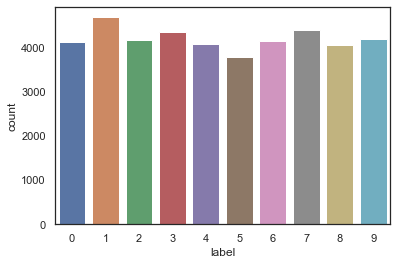

In [3]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

In [4]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

In [5]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [6]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [7]:
# Set the random seed
random_seed = 2

In [8]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)

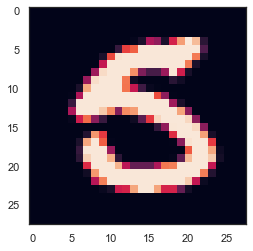

In [10]:
# Some examples
g = plt.imshow(X_train[4][:,:,0])

In [11]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(5,5),activation='relu',padding='same',input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10,activation='softmax'),
])

In [12]:
# Define the optimizer
optimizer = RMSprop()

In [13]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

ValueError: ('Could not interpret optimizer identifier:', <keras.optimizers.RMSprop object at 0x7f9b70ca3c10>)

In [43]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [44]:
epochs = 1 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

In [45]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [46]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/1
 - 168s - loss: 0.4285 - accuracy: 0.8620 - val_loss: 0.0644 - val_accuracy: 0.9817


/Users/nishanthkrishna/opt/anaconda3/envs/tf/lib/python3.7/site-packages/keras/callbacks/callbacks.py:1042: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning
